In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from tqdm import tqdm


In [5]:
data_dir = 'data_by_days'
NUM_TRAIN_FILES = 1

df = pd.concat([pd.read_feather(f'{data_dir}/train_{i}.feather') for i in tqdm(range(NUM_TRAIN_FILES))])
df.reset_index(drop=True, inplace=True)
df.head(5)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.45it/s]


,timestamp,target,MIRAMAR_bid0_price,MIRAMAR_bid0_qty,MIRAMAR_bid1_price,MIRAMAR_bid1_qty,MIRAMAR_bid2_price,MIRAMAR_bid2_qty,MIRAMAR_bid3_price,MIRAMAR_bid3_qty,...,LIVIK_ask0_price,LIVIK_ask0_qty,LIVIK_ask1_price,LIVIK_ask1_qty,LIVIK_ask2_price,LIVIK_ask2_qty,LIVIK_ask3_price,LIVIK_ask3_qty,LIVIK_ask4_price,LIVIK_ask4_qty
0,1970-01-01 02:00:00.000000000,-1.0,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
1,1970-01-01 02:00:00.499097340,47.5,26788.0,6.0,26787.0,4.0,26783.0,11.0,26782.0,1.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
2,1970-01-01 02:00:00.499100368,47.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
3,1970-01-01 02:00:00.499143008,48.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0
4,1970-01-01 02:00:00.502273623,48.5,26810.0,1.0,26805.0,10.0,26803.0,3.0,26801.0,28.0,...,18978.0,1.0,18980.0,2.0,18985.0,1.0,18988.0,3.0,18995.0,1.0


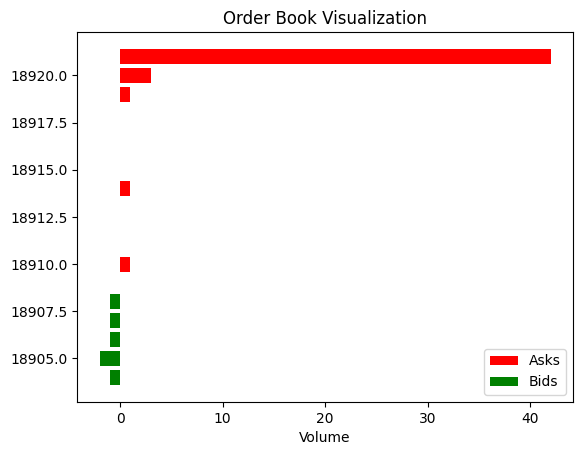

In [18]:
def draw_orderbook(df, number_of_snapshot, instrument='SANHOK'):
    ask_prices_columns = [column for column in df.columns if column.startswith(f'{instrument}_ask') and column.endswith('price')]
    bid_prices_columns = [column for column in df.columns if column.startswith(f'{instrument}_bid') and column.endswith('price')]
    ask_vol_columns = [column for column in df.columns if column.startswith(f'{instrument}_ask') and column.endswith('qty')]
    bid_vol_columns = [column for column in df.columns if column.startswith(f'{instrument}_bid') and column.endswith('qty')]
    assert number_of_snapshot < len(df)
    ask_prices = df.loc[number_of_snapshot, ask_prices_columns].values
    bid_prices = df.loc[number_of_snapshot, bid_prices_columns].values
    ask_volumes = df.loc[number_of_snapshot, ask_vol_columns].values
    bid_volumes = df.loc[number_of_snapshot, bid_vol_columns].values
    _, ax = plt.subplots()

    ax.barh(ask_prices, ask_volumes, color='red', label='Asks')
    
    ax.barh(bid_prices, -bid_volumes, color='green', label='Bids')

    ax.set_xlabel('Volume')
    ax.set_title('Order Book Visualization')

    ax.legend()
    plt.show()


draw_orderbook(df, 500)

In [20]:
@njit
def get_future_price(ts, values, window):
    price_pointer = 0
    res = np.zeros(ts.size)
    for X_pointer in range(len(ts)):
        while price_pointer + 1 < len(ts) and ts[price_pointer] < ts[X_pointer] + window:
            price_pointer += 1
        res[X_pointer] = values[price_pointer]
    return res

for i in tqdm(range(NUM_TRAIN_FILES)):
    day_df = pd.read_feather(f'{data_dir}/train_{i}.feather')
    ts = ((day_df.timestamp - pd.to_datetime('1970-01-01')) // pd.Timedelta('1ns')).values
    midprice = ((day_df.SANHOK_bid0_price + day_df.SANHOK_ask0_price) / 2).values
    window = pd.Timedelta('500ms') // pd.Timedelta('1ns')
    future_price = get_future_price(ts, midprice, window)
    assert all(day_df['target'] == get_future_price(ts, midprice, window) - midprice)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


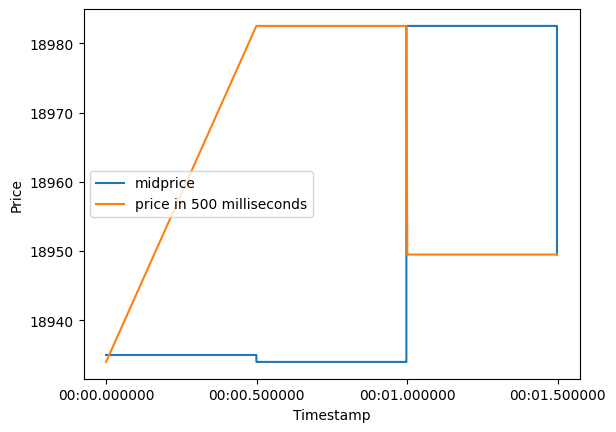

In [28]:
n = 16
_, ax = plt.subplots()
ax.plot(day_df.timestamp[:n], midprice[:n], label='midprice')
ax.plot(day_df.timestamp[:n], future_price[:n], label='price in 500 milliseconds')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price')
ax.legend()
plt.show()

In [30]:
day_df.timestamp[:n]

0    1970-01-01 02:00:00.000000000
1    1970-01-01 02:00:00.499097340
2    1970-01-01 02:00:00.499100368
3    1970-01-01 02:00:00.499143008
4    1970-01-01 02:00:00.502273623
5    1970-01-01 02:00:00.502305523
6    1970-01-01 02:00:00.502330560
7    1970-01-01 02:00:00.997164192
8    1970-01-01 02:00:00.997177117
9    1970-01-01 02:00:00.997186413
10   1970-01-01 02:00:01.000258177
11   1970-01-01 02:00:01.000261199
12   1970-01-01 02:00:01.000277143
13   1970-01-01 02:00:01.497243696
14   1970-01-01 02:00:01.497253198
15   1970-01-01 02:00:01.497262653
Name: timestamp, dtype: datetime64[ns]